/Users/jonathanyun/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3098: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


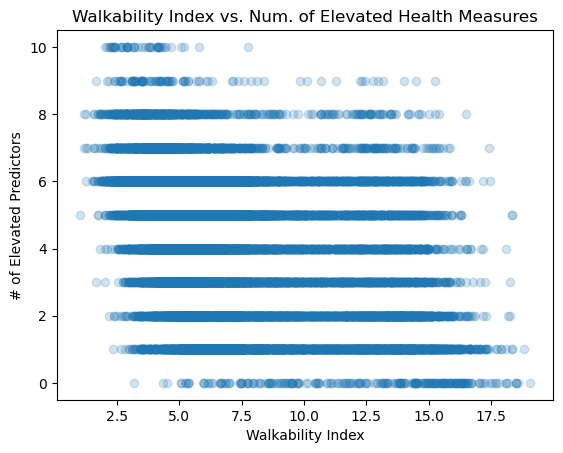

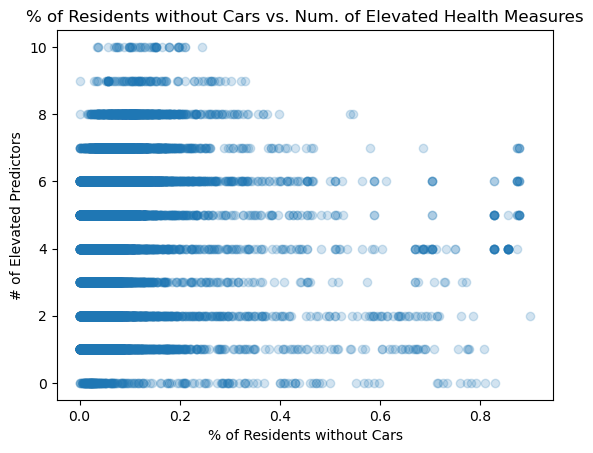

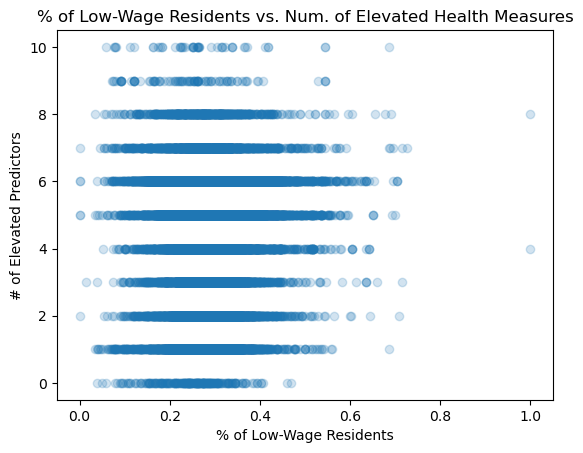

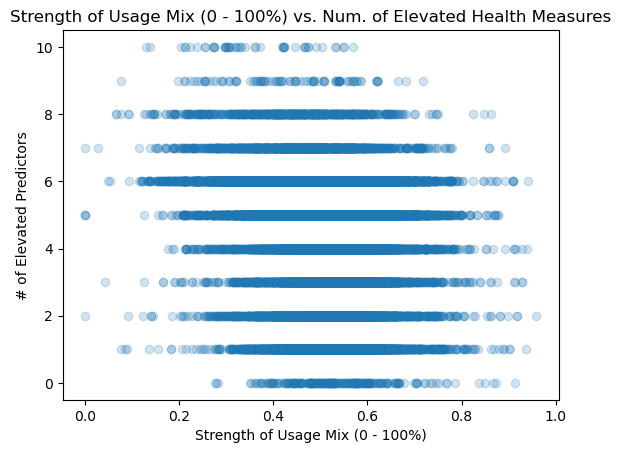

0.2379638863469803
0.0033070653860286514


In [1]:
import pandas as pd
import numpy as np

walkability = pd.read_csv("epa_walkability.csv")
health = pd.read_csv("places_health.csv")
relation = pd.read_csv("zcta_tract_relationship.txt", sep = "|")
match = relation[["GEOID_ZCTA5_20", "GEOID_TRACT_20"]]
match = match.dropna()
match['GEOID_TRACT_20'] = match['GEOID_TRACT_20'] / 1.0
walkability["GEOID_TRACT_20"] = walkability["STATEFP"].astype(str).str.rjust(2,'0') + walkability["COUNTYFP"].astype(str).str.rjust(3,'0')+walkability["TRACTCE"].astype(str).str.rjust(6,'0')
walkability["GEOID_TRACT_20"] = walkability["GEOID_TRACT_20"].astype(float)

len(walkability)
joined_walk = walkability.join(match.set_index("GEOID_TRACT_20"),on="GEOID_TRACT_20",lsuffix='_caller', rsuffix='_other')
walk_subset = joined_walk[['NatWalkInd', 'Pct_AO0', 'E_PctLowWage', 'D2A_EPHHM', 'GEOID_ZCTA5_20']]
walk_subset = pd.DataFrame(walk_subset.groupby("GEOID_ZCTA5_20").mean())
data_joined = health.set_index("LocationName").join(walk_subset).reset_index()
data_joined
health_values = data_joined.pivot(index = "index", columns = "MeasureId", values = "Data_Value")
health_values = health_values.join(walk_subset).reset_index()
health_values
health_values = health_values[["index", "ACCESS2", "CANCER", "ARTHRITIS", "COPD", "CHD", "OBESITY", "BPHIGH", "MHLTH", "PHLTH", "LPA", "NatWalkInd", "Pct_AO0", "E_PctLowWage", "D2A_EPHHM"]]

health_values
health_values = health_values.dropna()
health_values
#### Part IIa. Classifying Places with Elevated Rates of Health Issues 
# constants for health values

OB_AVERAGE = 41.9 
CANCER_AVERAGE = 5.42
ACCESS_AVERAGE = 8.6 
MHLTH_AVERAGE = 20.1 
LPA_AVERAGE = 25.0 
ARTH_AVERAGE = 24.0 
COPD_AVERAGE = 6.4 
CHD_AVERAGE = 5.5
BPHIGH_AVERAGE = 47
PHLTH_AVERAGE = 21.2 

### Linear Regression Models
binary_class = health_values.copy()

binary_class["ACCESS2"] = binary_class["ACCESS2"] > ACCESS_AVERAGE
binary_class["CANCER"] = binary_class["CANCER"] > CANCER_AVERAGE
binary_class["ARTHRITIS"] = binary_class["ARTHRITIS"] > ARTH_AVERAGE
binary_class["COPD"] = binary_class["COPD"] > COPD_AVERAGE
binary_class["CHD"] = binary_class["CHD"] > CHD_AVERAGE
binary_class["OBESITY"] = binary_class["OBESITY"] > OB_AVERAGE
binary_class["BPHIGH"] = binary_class["BPHIGH"] > BPHIGH_AVERAGE
binary_class["MHLTH"] = binary_class["MHLTH"] > MHLTH_AVERAGE
binary_class["PHLTH"] = binary_class["PHLTH"] > PHLTH_AVERAGE
binary_class["LPA"] = binary_class["LPA"] > LPA_AVERAGE

binary_class['NUM_ELEV'] = binary_class.drop(["NatWalkInd", "index", "Pct_AO0", "E_PctLowWage", "D2A_EPHHM"], axis = 1).apply(np.sum, axis = 1)
binary_class
import seaborn as sns
import matplotlib.pyplot as plt
plt.scatter(data = binary_class, x= 'NatWalkInd', y = "NUM_ELEV", alpha = 0.2)
plt.title("Walkability Index vs. Num. of Elevated Health Measures")
plt.xlabel("Walkability Index")
plt.ylabel("# of Elevated Predictors")
plt.show()
plt.scatter(data = binary_class, x= 'Pct_AO0', y = "NUM_ELEV", alpha = 0.2)
plt.title("% of Residents without Cars vs. Num. of Elevated Health Measures")
plt.xlabel("% of Residents without Cars")
plt.ylabel("# of Elevated Predictors")
plt.show()
plt.scatter(data = binary_class, x= 'E_PctLowWage', y = "NUM_ELEV", alpha = 0.2)
plt.title("% of Low-Wage Residents vs. Num. of Elevated Health Measures")
plt.xlabel("% of Low-Wage Residents")
plt.ylabel("# of Elevated Predictors")
plt.show()
plt.scatter(data = binary_class, x= 'D2A_EPHHM', y = "NUM_ELEV", alpha = 0.2)
plt.title("Strength of Usage Mix (0 - 100%) vs. Num. of Elevated Health Measures")
plt.xlabel("Strength of Usage Mix (0 - 100%)")
plt.ylabel("# of Elevated Predictors")
plt.show()
from sklearn.linear_model import LinearRegression

X = np.array(binary_class['NatWalkInd']).reshape(-1, 1)
y = binary_class['NUM_ELEV']

linear_test = LinearRegression().fit(X,y)
print(linear_test.score(X,y))
X = np.array(binary_class['E_PctLowWage']).reshape(-1, 1)
y = binary_class['NUM_ELEV']

linear_test = LinearRegression().fit(X,y)
print(linear_test.score(X,y))